# Multivariate Kalman Filter

In [48]:
import math
import scipy
import numpy as np
from scipy.linalg import pinv
from numpy.random import randn
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from filterpy.common import Saver
from filterpy.kalman import KalmanFilter
from kf_book.book_plots import set_figsize
import kf_book.book_plots as book_plots 
import kf_book.mkf_internal as mkf_internal
from filterpy.kalman import predict, update
from kf_book.mkf_internal import plot_track
from filterpy.stats import plot_3d_covariance
from filterpy.stats import multivariate_multiply
from filterpy.common import Q_discrete_white_noise
from filterpy.stats import plot_covariance_ellipse
from kf_book.mkf_internal import plot_track_ellipses
from kf_book.nonlinear_plots import plot_gaussians
from kf_book.gaussian_internal import plot_correlated_data
from filterpy.stats import gaussian, multivariate_gaussian
from kf_book.nonlinear_plots import plot_cov_ellipse_colormap
from kf_book.book_plots import figsize, FloatSlider, IntSlider

## Newton's Equation of Motion

$$\LARGE x = vt + x_{0}$$

$$\LARGE x = \frac{1}{2}at^{2} + v_{0}t + x_{0}$$

## Kalman Filter Algorithum

### Initialization

<font size="5">
    
1. Initialize the state of the filter
    
2. Initialize our belief in the state</font>

### Predict

<font size="5">
    
1. Use process model to predict state at the next time step

2. Adjust belief to account for the uncertainty in prediction
</font>

### Update

<font size="5">
    
1. Get a measurement and associated belief about its accuracy

2. Compute residual between estimated state and measurement

3. Compute scalling factor based on whether the measurement or prediction is more accuracte

4. Set state between the prediction and measurement based on scalling factor

5. Update belief in the state based on how certain we are in the measurement
</font>

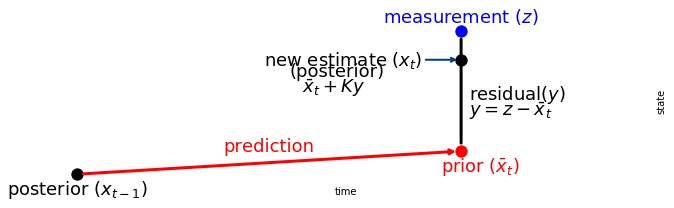

In [49]:
book_plots.show_residual_chart()

In [50]:
def compute_dog_data(z_var, process_var, count = 1, dt = 1):
    x, vel = 0.0, 1.0
    z_std = math.sqrt(z_var)
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v * dt
        xs. append(x)
        zs.append(x + randn() * z_std)
    return np.array(xs), np.array(zs)

### Design State Variable

<font size="3">In one dimension Gaussian, the mean($\mu$) represented the most likely position, and the variance($\sigma^{2}$) represented the probability distribution of the position. The position is the **state** of the system, and we call **$\mu$** the state variable</font>

In [51]:
x = np.array([[1000.0, 4.5]]).T
print(x)

[[1000. ]
 [   4.5]]


### Design State Covariance

<font size="3">Covariance matrix **P**. In univariate Kalman filter we specified an initial value for $\sigma^{2}$. We specify an inital value for **P** and the filter updates it during each epoch.</font>

In [52]:
P = np.diag([500.0, 49.0])
print(P)

[[500.   0.]
 [  0.  49.]]


### Design the Process Model

<font size="3">The process model is a mathematical model which describes the behavior of the system. The filter uses it to predict the state after a discrete time step.</font>

$$\Large x = v\Delta t + x_{0}$$

In [53]:
#def predict(pos, movement):
#    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

In [54]:
dt = 0.1
F = np.array([[1, dt], 
              [0, 1]])
print(F)

[[1.  0.1]
 [0.  1. ]]


In [55]:
x = np.array([10.0, 4.5])
P = np.diag([500.0, 49.0])
dt = 0.1
F = np.array([[1, dt],
              [0, 1]])
x, P = predict(x = x, P = P, F = F, Q = 0)
print('x = ', x)

x =  [10.45  4.5 ]


In [56]:
for _ in range(4):
    x, P = predict(x = x, P = P, F = F, Q = 0)
    print('x = ', x)
print('P = ', P)

x =  [10.9  4.5]
x =  [11.35  4.5 ]
x =  [11.8  4.5]
x =  [12.25  4.5 ]
P =  [[512.25  24.5 ]
 [ 24.5   49.  ]]


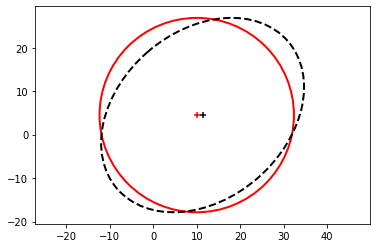

In [57]:
dt = 0.3
F = np.array([[1, dt], [0, 1]])
x = np.array([10.0, 4.5])
P = np.diag([500, 500])
plot_covariance_ellipse(x, P, edgecolor = 'r')
x, P = predict(x = x, P = P, F = F, Q = 0)
plot_covariance_ellipse(x, P, edgecolor = 'k', ls = 'dashed')

In [58]:
Q = Q_discrete_white_noise(dim = 2, dt = 1, var = 2.35)
print(Q)

[[0.5875 1.175 ]
 [1.175  2.35  ]]


### Design the Control Function

<font size="3">For a linear system, the effect of control inputs can be described as a set of linear equations, which we can express with linear algebra as:

**$$\Delta x = Bu$$**</font>

Here **u** is the control input, and **B** is the control input model or control function.

Therefore the complete Kalman Filter equation for the prior mean is:

$$\Large \bar{\textbf{x}} = \textbf{Fx + Bu}$$

In [59]:
# Dog doesn't listen to me
B = 0
u = 0

x, P = predict(x, P, F, Q, B, u)
print('x = ',x)
print('P = ',P)

x =  [12.7  4.5]
P =  [[680.5875 301.175 ]
 [301.175  502.35  ]]


In [60]:
print(predict(x, P, F, Q)[0] == predict(x, P, F, Q, B, u)[0])
print(predict(x, P, F, Q)[1] == predict(x, P, F, Q, B, u)[1])

[ True  True]
[[ True  True]
 [ True  True]]


## Summary
<br>
<font size="4">
$\textbf{x, P}$: The state and covariance

$\textbf{F, Q}$: The process model and noise covariance

$\textbf{B, u}$: Optionally, the control input and function</font>

### Design the Measurement Function

$$\Large  \textbf{y} = \textbf{z} - \textbf{H}\bar{\textbf{x}}$$
<br>
<font size="4">
Where **y** is residual, $\bar{\textbf{x}}$ is the prior, **z** is the measurement, and **H** is the measurement function.</font>

In [61]:
H = np.array([[1.0, 0.0]])
R = np.array([[5.0, 0.0],
              [0.0, 3.0]])
z = 1.0
x, P = predict(x, P, z, R, H)
print('x = ', x)

x =  [[13.7  4.5]]


In [62]:
dog_filter = KalmanFilter(dim_x = 2, dim_z = 1)
print('x = ', dog_filter.x.T)
print('R = ', dog_filter.R)
print('Q = \n', dog_filter.Q)

x =  [[0. 0.]]
R =  [[1.]]
Q = 
 [[1. 0.]
 [0. 1.]]


In [63]:
def pos_vel_filter(x, P, R, Q = 0, dt = 1.0):
    kf = KalmanFilter(dim_x = 2, dim_z = 1)
    kf.x = np.array([x[0], x[1]])
    kf.F = np.array([[1, dt],
                     [0, 1]])
    kf.H = np.array([[1.0, 0.0]])
    kf.R *= R
    if np.isscalar(P):
        kf.P *= P
    else:
        kf.P[:] = P
    
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim = 2, dt = dt, var = Q)
    else:
        kf.Q[:] = Q
    return kf

In [64]:
dt = 0.1
x = np.array([0.0, 0.0])
kf = pos_vel_filter(x, P = 500, R = 5, Q = 0.1, dt = dt)
kf

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [0. 0.]
P = [[500.   0.]
     [  0. 500.]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1.  0.1]
     [0.  1. ]]
Q = [[2.5e-06 5.0e-05]
     [5.0e-05 1.0e-03]]
R = [[5.]]
H = [[1. 0.]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x000002A36F971798>

In [65]:
def run(x0 = (0.0, 0.0), P = 500, R = 0, Q = 0, dt = 1.0, track = None, zs = None, count = 0, do_plot = True, **kwargs):
    if zs is None:
        track, zs = compute_dog_data(R, Q, count)
    
    kf = pos_vel_filter(x0, R = R, P = P, Q = Q, dt = dt)
    
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)
        
    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, dt = dt, **kwargs)
    return xs, cov

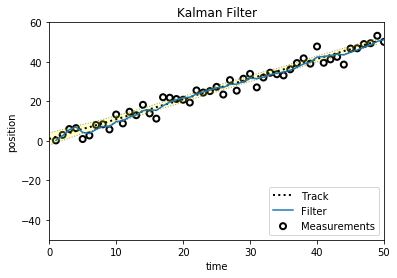

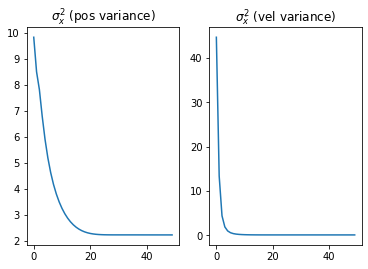

In [19]:
P = np.diag([500.0, 49.0])
Ms, Ps = run(count = 50, R = 10, Q = 0.01, P = P)

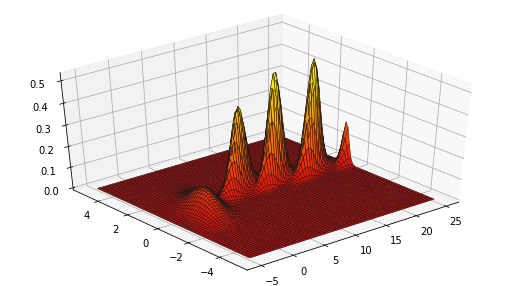

In [20]:
P = np.diag([3.0, 1.0])
np.random.seed(3)
Ms, Ps = run(count = 50, R = 10, Q = 0.01, P = P, do_plot = False)
with figsize(x = 9, y = 5):
    plot_gaussians(Ms[::7], Ps[::7], (-5, 25), (-5, 5), 75)

In [21]:
kf = pos_vel_filter([0, 0.1], R = 10, P = P, Q = Q, dt = 1.0)
s = Saver(kf)
for i in range(1, 6):
    kf.predict()
    kf.update([i])
    s.save()
s.x

[array([0.38303342, 0.23419023]),
 array([1.29950638, 0.63289085]),
 array([2.57334998, 0.96537627]),
 array([3.82578605, 1.10382319]),
 array([4.97337308, 1.12458909])]

In [22]:
s.keys

['alpha',
 'likelihood',
 'log_likelihood',
 'mahalanobis',
 'dim_x',
 'dim_z',
 'dim_u',
 'x',
 'P',
 'Q',
 'B',
 'F',
 'H',
 'R',
 '_alpha_sq',
 'M',
 'z',
 'K',
 'y',
 'S',
 'SI',
 '_I',
 'x_prior',
 'P_prior',
 'x_post',
 'P_post',
 '_log_likelihood',
 '_likelihood',
 '_mahalanobis',
 'inv']

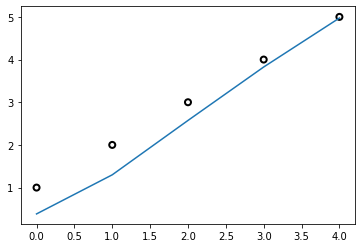

In [23]:
s.to_array()
book_plots.plot_measurements(s.z)
plt.plot(s.x[:, 0])

# Prediction Equations
<br>
$$\Large \bar{\textbf{x}} = \textbf{Fx + Bu}$$
<br>
$$\Large \bar{\textbf{P}} = \textbf{FPF}^{\textbf{T}} + \textbf{Q}$$
<br>

## Mean

**F** contains the state transition for a given function, and the **Fx** computes the state after that transition
<br>
**B** is the control function, **u** is the control input, so **Bu** computes the contribution of the controls to the state after the transition.

Thus, the prior $\bar{x}$ is computed as the sum of **Fx** and **Bu**


The equivalent univariate equation is $\bar{\mu} = \mu + \mu_{move}$

## Covariance

In univariate version of this equation is:
$$\bar{\sigma}^{2} = \sigma^{2} + \sigma^2_{move}$$

We add the variance of the movement to the variance of our estimate to reflect the loss of knowldge. We need to do the same thing here.

We can't simply write $\bar{P} = P + Q$. In a multivariate Gaussians the state variables are correlated. Our knowledge of the velocity is imperfect, but we are adding it to the position with:
$$\bar{x} = \dot{x}\Delta t + x$$

Since we do not have perfect knowledge of the value of $\dot{x}$, the sum $\bar{x} = \dot{x}\Delta t + x$ gains uncertainty. Because the position and velocities are correlated we cannot simply add the covariance matries.

The correct equation is:
$$\Large \bar{\textbf{P}} = \textbf{FPF}^T + \textbf{Q}$$

When we initialize **P** with:
$$\Large P = \begin{bmatrix}
\sigma^{2}_{x} & 0 \\
0 & \sigma^{2}_{v}  
\end{bmatrix}$$

the value of $\textbf{FPF}^{\textbf{T}}$ is:

$$
\Large 
\begin{equation}
\begin{aligned} 
\textbf{FPF}^{\textbf{T}} &= \begin{bmatrix} 1 & \Delta t \\ 0 & 1\end{bmatrix}\begin{bmatrix} \sigma^{2}_{x} & 0 \\ 0 & \sigma^{2}_{v}\end{bmatrix}\begin{bmatrix} 1 & 0 \\ \Delta t & 1\end{bmatrix} \\ 
&= \begin{bmatrix} \sigma^{2}_{x} & \sigma^{2}_{v}\Delta t \\ 0 & \sigma^{2}_{v}\end{bmatrix}\begin{bmatrix} 1 & 0 \\ \Delta t & 1\end{bmatrix} \\
&= \begin{bmatrix} \sigma^{2}_{x} + \sigma^{2}_{v}\Delta t & \sigma^{2}_{v}\Delta t \\ \sigma^{2}_{v}\Delta t & \sigma^{2}_{v}\end{bmatrix}
\end{aligned}
\end{equation}
$$

$$
\Large 
\begin{aligned} 
\bar{P} &= E[(\textbf{Fx})(\textbf{Fx}^T)] \\
&= E(Fxx^{T}F^{T}) \\
&= FE[xx^{T}]F^{T}
\end{aligned}
$$

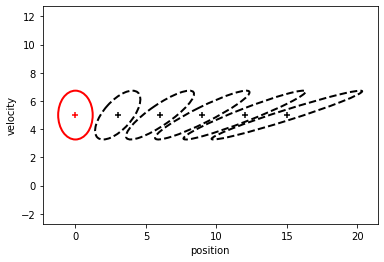

In [24]:
dt = 0.6
x = np.array([0.0, 5.0])
F = np.array([[1, dt], [0, 1.0]])
P = np.array([[1.5, 0], [0, 3.0]])
plot_covariance_ellipse(x, P, edgecolor = 'r')
for _ in range(5):
    x = np.dot(F, x)
    P = np.dot(F, P).dot(F.T)
    plot_covariance_ellipse(x, P, edgecolor = 'k', ls = 'dashed')
book_plots.set_labels(x = 'position', y = 'velocity')

In [25]:
def plot_FPFT(F00, F01, F10, F11, covar):
    plt.figure()
    dt = 1.0
    x = np.array([0.0, 0.0])
    P = np.array([[1, covar], [covar, 2]])
    F = np.array([[F00, F01],[F10, F11]])
    plot_covariance_ellipse(x, P)
    plot_covariance_ellipse(x, np.dot(F, P).dot(F.T), ec = 'r')
    plt.gca().set_aspect('equal')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.xlabel('Position')
    plt.ylabel('Velocity')

interact(plot_FPFT, F00 = IntSlider(value = 1, min = 0, max = 2), 
                    F01 = FloatSlider(value = 1, min = 0, max = 2, description = 'F01(dt)'),
                    F10 = FloatSlider(value = 0, min = 0, max = 2),
                    F11 = FloatSlider(value = 1, min = 0, max = 2),
                    covar = FloatSlider(value = 1, min = 0, max = 1))
    

interactive(children=(IntSlider(value=1, continuous_update=False, description='F00', max=2), FloatSlider(value…

<function __main__.plot_FPFT(F00, F01, F10, F11, covar)>

# Update Equations

## System Uncertainty

$$\Large \textbf{S} = \textbf{H}\bar{\textbf{P}}\textbf{H}^{T} + \textbf{R}$$

Where $\bar{\textbf{P}}$ is the prior covariance and $\textbf{H}$ is the measurement function.

The prediction step used $\textbf{FPF}^T$ to update $\textbf{P}$ with the state transition function. Here, we use the same form to update it with the measurement function. The linear algebra is changing the coordinate system.

Compare the equation for the system uncertainty and the covariance

$$
\Large 
\textbf{S} = \textbf{H}\bar{\textbf{P}}\textbf{H}^{T} + \textbf{R}\\
\Large
\bar{\textbf{P}} = \textbf{FPF}^{\textbf{T}} + \textbf{Q}
$$

In each equaiton, **P** is put into a different space wotj eith the function **H** or **F**.

## Kalman Gain

$$\Large \textbf{K} = \bar{\textbf{P}}\textbf{H}^{T}\textbf{S}^{-1}$$

In univariate, we scaled the mean using this equation:

$$\Large \mu = \frac{\bar{\sigma}^{2}\mu_{2} + \sigma^{2}_{z}\bar{\mu}}{\bar{\sigma}^{2} + \sigma^{2}_{z}}$$

which can be simplified to:

$$\Large \mu = (1 - K)\bar{\mu} + K\mu_{z}$$,

which give us:

$$\Large K = \frac{\bar{\sigma}^{2}}{\bar{\sigma}^{2} + \sigma^{2}_{z}}$$

K is the **Kalman Gain**, and it is a real number between 0 and 1,.If Kalman gain is 0.9, which means it takes 90% of the measurement and 10% of the prediction.

For the multivariate Kalman filter **K** is a vector, not a scalar.

$$\Large
\textbf{K} \approx \frac{\bar{\textbf{P}}\textbf{H}^T}{\textbf{S}}
\\
\Large
\textbf{K} \approx \frac{Uncertainty_{prediction}}{Uncertainty_{measurement}}\textbf{H}^T
$$

Therefore, the Kalman gain equation can be seem as a ratio based on how much we trust the prediction vs the measurement.


## Residual

$$\Large \textbf{y} = \textbf{z} - \textbf{H}\bar{\textbf{x}}$$

The measurement function converts a state into a measurement. So **Hx** converts **x** into an equivcalent measurement. Once that is done, we can subtract it from the measurememnt **z** to get the residual(the differenece between the measurement and prediction).

The univariate equation is:
$$\Large y = z - \bar{x}$$

## State Update

$$\Large \textbf{x} = \bar{\textbf{x}} + \textbf{Ky}$$

We select our new state to be along the residual, scaled by the Kalman gain. The scaling is performed by **Ky**, which both scales the residualand convert it back into state space with the $\textbf{H}^T$ term which is in **K**.
$$
\Large
\begin{align}
\textbf{x} &= \bar{\textbf{x}} + \textbf{Ky} \\
& = \bar{\textbf{x}} + \bar{\textbf{P}}\textbf{H}^{T}\textbf{S}^{-1}\textbf{y} \\
& \approx \bar{\textbf{x}} + \frac{Uncertainty_{prediction}}{Uncertainty_{measurement}}\textbf{H}^T
\end{align}
$$

Rewrite above equation:

$$
\Large
\begin{align}
\textbf{x} &= \bar{\textbf{x}} + \textbf{Ky} \\
&= \bar{\textbf{x}} + \textbf{K}(\textbf{z} - \textbf{H}\bar{\textbf{x}}) \\
&= (\textbf{I} - \textbf{KH})\bar{\textbf{x}} + \textbf{Kz}
\end{align}
$$

The univariate form is:

$$\Large \mu = (1 - K)\bar{\mu} + K\mu_{z}$$

## Covariance Update

$$\Large \textbf{P} = (\textbf{I} - \textbf{KH})\bar{\textbf{P}}$$

Where **I** is identity matrix, **H** is measurement function,and is a constant.

In [26]:
dt = 1
R_var = 10
Q_var = 0.01
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])
F = np.array([[1, dt], 
              [0, 1]])
H = np.array([[1.0, 0.0]])
R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim = 2, dt = dt, var = Q_var)

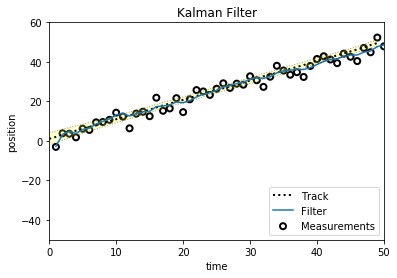

In [27]:
count = 50
track, zs = compute_dog_data(R_var, Q_var, count)
xs, cov = [], []

for z in zs:
    # Predict
    x = np.dot(F, x)
    P = np.dot(F, P).dot(F.T) + Q
    
    # Update
    S = np.dot(H, P).dot(H.T) + R
    K = np.dot(P, H.T).dot(np.linalg.inv(S))
    y = z - np.dot(H, x)
    x += np.dot(K, y)
    P = P - np.dot(K, H).dot(P)
    
    xs.append(x)
    cov.append(P)
xs, cov = np.array(xs), np.array(cov)
plot_track(xs[:,0], track, zs, cov, plot_P = False, dt = dt)

In [46]:
zs

array([ 0.17012393,  0.29658619, -0.70897248,  3.2057141 ,  5.13735991,
        3.20778697,  7.06525702,  6.98573033,  8.34591748, 11.88184834,
       13.69945135, 13.71458163, 12.78738479, 13.33345667, 16.8349744 ,
       16.13135891, 16.25743617, 18.60451102, 19.8744551 , 21.98842486,
       20.13861857, 25.50179025, 22.47424937, 28.24230633, 26.69057791,
       26.05388663, 26.89734544, 29.48894385, 31.20424896, 32.16503047,
       33.69526432, 32.08146031, 33.5359651 , 37.45929565, 33.71718014,
       36.05799371, 39.47195596, 35.49646915, 41.38981476, 42.308103  ,
       41.6090958 , 43.69343302, 44.21737557, 45.57036024, 47.88995223,
       47.42388163, 46.94379448, 49.24395607, 50.13688286, 52.18271648])

# Summary

## Predict Step

$$
\Large
\begin{align}
\bar{\textbf{x}} &= \textbf{Fx} + \textbf{Bu} \\
\bar{\textbf{P}} &= \textbf{FPF}^{T} + \textbf{Q}
\end{align}
$$

## Update Step

$$
\Large
\begin{align}
\textbf{S} &= \textbf{H}\bar{\textbf{P}}\textbf{H}^{T} + \textbf{R}  \\
\textbf{K} &= \bar{\textbf{P}}\textbf{H}^{T}\textbf{S}^{-1} \\
\textbf{y} &= \textbf{z} - \textbf{H}\bar{\textbf{x}}\\
\textbf{x} &= \bar{\textbf{x}} + \textbf{Ky} \\
\textbf{P} &= (\textbf{I} - \textbf{KH})\bar{\textbf{P}}
\end{align}
$$

# Literature Equation

## Predict Step
$$
\Large
\begin{align}
\hat{\textbf{x}}_{k\mid k-1} &= \textbf{F}_{k}\hat{\textbf{x}}_{k-1 \mid k-1} + \textbf{B}_{k}\textbf{u}_{k}\\
\textbf{P}_{k\mid k-1} &= \textbf{F}_{k}\textbf{P}_{k-1 \mid k-1}\textbf{F}^{T}_{k} + \textbf{Q}_{k}
\end{align}
$$


## Update Step

$$
\Large
\begin{align}
\tilde{\textbf{y}}_{k} &= \textbf{z}_{k} - \textbf{H}_{k}\hat{\textbf{x}}_{k \mid k-1} \\
\textbf{S}_{k} &= \textbf{H}_{k}\textbf{P}_{k \mid k-1}\textbf{H}^{T}_{k} + \textbf{R}_{k} \\
\textbf{K}_{k} &= \textbf{P}_{k \mid k-1}\textbf{H}^{T}_{k}\textbf{S}^{-1}_{k} \\
\hat{\textbf{x}}_{k \mid k} &= \hat{\textbf{x}}_{k \mid k-1} + \textbf{K}_{k}\tilde{\textbf{y}}_{k} \\
\textbf{P}_{k \mid k} &= (\textbf{I} - \textbf{K}_{k}\textbf{H}_{k})\textbf{P}_{k \mid k-1}
\end{align} 
$$

The notationn uses the Baysian $a \mid b$ notation, which means a given the evidence of b.

The hat means estimate. Thus $\hat{\textbf{x}}_{k\mid k}$ means posterior, and $\hat{\textbf{x}}_{k\mid k-1}$ means prior


## Exercise: Show effect of Hidden Variables

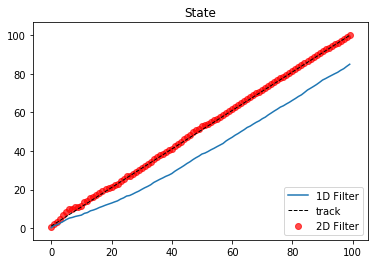

In [28]:
def univariate_filter(x0, P, R, Q):
    f = KalmanFilter(dim_x = 1, dim_z = 1, dim_u = 1)
    f.x = np.array(x0)
    f.P *= P
    f.H = np.array([[1.0]])
    f.F = np.array([[1.0]])
    f.B = np.array([[1.0]])
    f.Q *= Q
    f.R *= R
    return f

def plot_1d_2d(xs, xs1d, xs2d):
    plt.plot(xs1d, label = '1D Filter')
    plt.scatter(range(len(xs2d)), xs2d, c = 'r', alpha = 0.7,label = '2D Filter')
    plt.plot(xs, ls  = '--', color = 'k', lw = 1, label = 'track')
    plt.title('State')
    plt.legend(loc = 4)
    plt.show()
    
def compare_1D_2D(x0, P, R, Q, vel, u = 0):
    xs, xs1, xs2 = [], [], []
    f1D = univariate_filter(x0, P, R, Q)
    
    f2D = pos_vel_filter(x = (x0, vel), P = P, R = R, Q = 0)
    
    pos = 0
    
    for i in range(100):
        pos += vel
        xs.append(pos)
        
        f1D.predict(u = u)
        f2D.predict()
        
        z = pos + randn() * math.sqrt(R)
        
        f1D.update(z)
        f2D.update(z)
        
        xs1.append(f1D.x[0])
        xs2.append(f2D.x[0])
    plt.figure()
    plot_1d_2d(xs, xs1, xs2)
compare_1D_2D(x0 = 0, P = 50, R = 5, Q = 0.02, vel = 1.0)

### Control input equal actual velocity

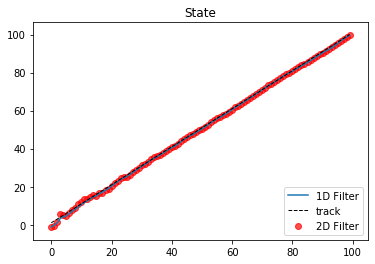

In [29]:
compare_1D_2D(x0 = 0, P = 50, R = 5, Q = 0.02, vel = 1, u = 1.0)

### Control input unequal to actual velocity 

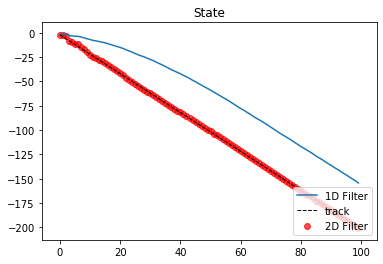

In [30]:
compare_1D_2D(x0 = 0, P = 50, R = 5, Q = 0.02, vel = -2, u = 1.0)

## Compute the Velocity

### 1: we need to compute the system uncertainty

$$
\Large 
\begin{align}
\textbf{S} &= \textbf{H}\bar{\textbf{P}}\textbf{H}^{T} + \textbf{R} \\
&= \begin{bmatrix} 1 & 0 \end{bmatrix}\begin{bmatrix} \sigma^{2}_{x}& \sigma_{xv} \\ \sigma_{xv} & \sigma^{2}_{v} \end{bmatrix}\begin{bmatrix} 1 \\ 0 \end{bmatrix} + \begin{bmatrix} \sigma^{2}_{z} \end{bmatrix} \\
&= \begin{bmatrix} \sigma^{2}_{x} \\ \sigma_{xv} \end{bmatrix}\begin{bmatrix} 1 \\ 0 \end{bmatrix}+ \begin{bmatrix} \sigma^{2}_{z} \end{bmatrix} \\
&= \begin{bmatrix} \sigma^{2}_{x} + \sigma^{2}_{z} \end{bmatrix}
\end{align}
$$

### 2: find the value for the Kalman gain

$$
\Large 
\begin{align}
\textbf{K} &= \bar{\textbf{P}}\textbf{H}^{T}\textbf{S}^{-1} \\
&= \begin{bmatrix} \sigma^{2}_{x} & \sigma_{xv} \\ \sigma_{xv} &\sigma^{2}_{v}\end{bmatrix}\begin{bmatrix} 1 \\ 0 \end{bmatrix}\begin{bmatrix} \frac{1}{\sigma^{2}_{x}+\sigma^{2}_{z}} \end{bmatrix} \\
&= \begin{bmatrix} \sigma^{2}_{x}  \\ \sigma_{xv} \end{bmatrix}\begin{bmatrix} \frac{1}{\sigma^{2}_{x}+\sigma^{2}_{z}} \end{bmatrix} \\
&= \begin{bmatrix} \frac{\sigma^{2}_{x}}{\sigma^{2}_{x}+\sigma^{2}_{z}}  \\ \frac{\sigma_{xv}}{\sigma^{2}_{x}+\sigma^{2}_{z}} \end{bmatrix}
\end{align}
$$

In other words, the Kalman gain for x is:

$$
\Large 
K_{x} = \frac{VAR(x)}{VAR_{x} + VAR_{z}}
$$

the Kalman gain for $\dot{x}$ is:

$$
\Large
K_{\dot{x}} = \frac{COV(x, \dot{x})}{VAR(x) + VAR(\dot{x})}
$$

Recall the state:

$$
\Large 
\begin{align}
\textbf{x} &= \bar{\textbf{x}} + \textbf{K}(z - \textbf{Hx})\\
&= \bar{\textbf{x}} + \textbf{K}y
\end{align}
$$

$$
\Large
\begin{align}
\begin{bmatrix} x  \\ \dot{x} \end{bmatrix} = \begin{bmatrix} \bar{x}  \\ \bar{\dot{x}} \end{bmatrix} + \begin{bmatrix} K_{x}  \\ K_{\dot{x}} \end{bmatrix}y
\end{align}
$$

Which give this system of equations:

$$
\Large
\begin{align}
x &= \bar{x} + yK_{x} \\
\dot{x} &= \bar{\dot{x}} + yK_{\dot{x}}
\end{align}
$$

If the prediction was perfect then the residual will be y = 0, and the velocity will unchanged. 

If the velocity estimate was very bad, then the prediction will be very bad, and the residual will be large. We will update the velocity estimate with $yK_{\dot{x}}$. $yK_{\dot{x}}$ is proportional to $COV(x, \dot{x})$.

Therefore, the velocity is updated by error in the position times the value proportional to the covariance between the position and velocity. The higher the correlation the larger the correctiuon.


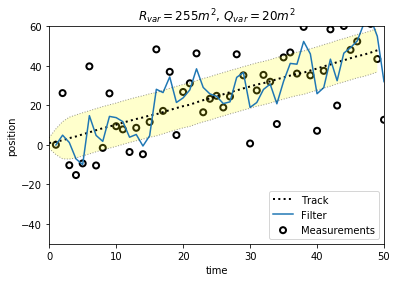

(array([[ 3.27403701e-03,  4.31560245e-03],
        [ 4.94900762e+00,  3.75382648e+00],
        [ 1.25893926e+00, -1.36109907e-01],
        [-7.03439073e+00, -3.57621003e+00],
        [-9.93515954e+00, -3.31786151e+00],
        [ 1.48265339e+01,  7.15346792e+00],
        [ 4.83702187e+00,  7.35165730e-01],
        [ 1.82735538e+00, -6.78144325e-01],
        [ 1.44504857e+01,  4.36343030e+00],
        [ 1.38300394e+01,  2.47237891e+00],
        [ 1.17966687e+01,  7.63159016e-01],
        [ 3.92333558e+00, -2.51171562e+00],
        [ 5.30593226e+00, -1.03535041e+00],
        [-5.26103711e-01, -2.85370402e+00],
        [ 4.66200699e+00,  1.94849848e-01],
        [ 2.81682873e+01,  9.03207502e+00],
        [ 2.65053553e+01,  4.97762316e+00],
        [ 3.44369322e+01,  6.09746290e+00],
        [ 2.14994337e+01, -1.11866164e+00],
        [ 2.38244541e+01,  1.86831817e-01],
        [ 2.78595307e+01,  1.64569361e+00],
        [ 3.85211421e+01,  5.06360922e+00],
        [ 2.90917398e+01, -4.306

In [31]:
np.random.seed(2)

track, zs = compute_dog_data(z_var = 225, process_var = 0.02, count = 50)

run(track = track, zs = zs, R = 225, Q = 20, P = P, plot_P = False, title = '$R_{var} = 255 m^{2}$, $Q_{var} = 20 m^{2}$')

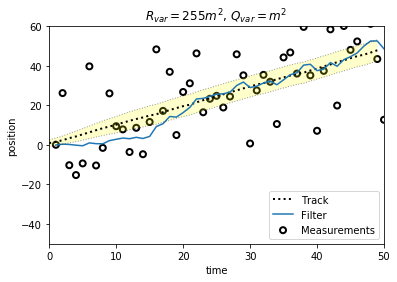

(array([[ 1.21813837e-03,  1.54866309e-04],
        [ 4.19256140e-01,  5.33072506e-02],
        [ 2.57343413e-01,  2.62963221e-02],
        [-1.05464194e-01, -2.13390391e-02],
        [-4.11460762e-01, -5.50533366e-02],
        [ 1.04469514e+00,  1.17189983e-01],
        [ 6.44336236e-01,  6.05905079e-02],
        [ 5.90174888e-01,  4.85638959e-02],
        [ 2.18336007e+00,  2.03717081e-01],
        [ 2.87603470e+00,  2.50835642e-01],
        [ 3.49216676e+00,  2.84661891e-01],
        [ 3.15851360e+00,  2.29529735e-01],
        [ 3.87084064e+00,  2.71080427e-01],
        [ 3.28139661e+00,  1.99414432e-01],
        [ 4.32062422e+00,  2.67278388e-01],
        [ 9.30878174e+00,  6.38454799e-01],
        [ 1.07630750e+01,  7.01038176e-01],
        [ 1.44054110e+01,  9.21772808e-01],
        [ 1.41106567e+01,  8.32220645e-01],
        [ 1.63673433e+01,  9.35337188e-01],
        [ 1.89937513e+01,  1.05600749e+00],
        [ 2.32833812e+01,  1.28396935e+00],
        [ 2.35714112e+01,  1.214

In [32]:
run(track = track, zs = zs, R = 225, Q = 0.02, P = P, plot_P = False, title = '$R_{var} = 255 m^{2}$, $Q_{var} =   m^{2}$')

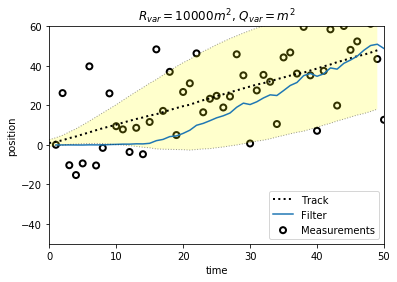

(array([[ 2.81850492e-05,  4.40103361e-06],
        [ 1.08807451e-02,  2.17669099e-03],
        [ 6.58733490e-03,  7.39631161e-04],
        [-7.64057838e-03, -2.57100592e-03],
        [-2.42596680e-02, -5.49959460e-03],
        [ 5.95248148e-02,  1.16379556e-02],
        [ 3.74495344e-02,  5.72474162e-03],
        [ 3.63560617e-02,  4.63217587e-03],
        [ 1.98914210e-01,  2.78221750e-02],
        [ 3.00593367e-01,  3.78036448e-02],
        [ 4.15608842e-01,  4.74530807e-02],
        [ 4.11373288e-01,  4.14513114e-02],
        [ 5.82964024e-01,  5.55546655e-02],
        [ 5.36710128e-01,  4.52134258e-02],
        [ 8.33483242e-01,  6.92585036e-02],
        [ 2.16932436e+00,  1.83604114e-01],
        [ 2.81192760e+00,  2.22877177e-01],
        [ 4.22848508e+00,  3.19988016e-01],
        [ 4.56670561e+00,  3.21402631e-01],
        [ 5.85310278e+00,  3.93011964e-01],
        [ 7.45462944e+00,  4.79017550e-01],
        [ 9.95945643e+00,  6.17636916e-01],
        [ 1.09162280e+01,  6.400

In [33]:
run(track = track, zs = zs, R = 10000, Q = 0.2, P = P, plot_P = False, title = '$R_{var} = 10000 m^{2}$, $Q_{var} =   m^{2}$')

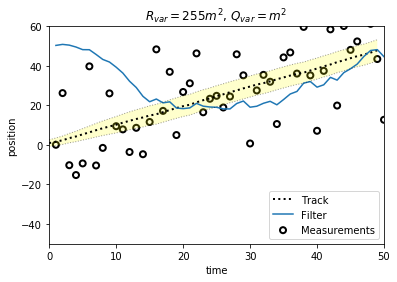

(array([[ 5.03611438e+01,  9.18779919e-01],
        [ 5.08812255e+01,  8.68067738e-01],
        [ 5.05039867e+01,  7.11777018e-01],
        [ 4.95486235e+01,  5.07680319e-01],
        [ 4.82191790e+01,  2.90094752e-01],
        [ 4.81809485e+01,  2.52673166e-01],
        [ 4.57960317e+01, -3.57753444e-02],
        [ 4.32742930e+01, -2.96317682e-01],
        [ 4.19529776e+01, -3.99276031e-01],
        [ 3.93479254e+01, -6.11836417e-01],
        [ 3.63691391e+01, -8.31014673e-01],
        [ 3.22435217e+01, -1.12477842e+00],
        [ 2.90715476e+01, -1.30096499e+00],
        [ 2.46056767e+01, -1.56454394e+00],
        [ 2.18649238e+01, -1.65959150e+00],
        [ 2.32420017e+01, -1.42083511e+00],
        [ 2.13086716e+01, -1.46014886e+00],
        [ 2.18239281e+01, -1.31190125e+00],
        [ 1.86841854e+01, -1.44645407e+00],
        [ 1.83866829e+01, -1.36328191e+00],
        [ 1.87484718e+01, -1.24018546e+00],
        [ 2.10546012e+01, -9.90179614e-01],
        [ 1.96268976e+01, -1.020

In [34]:
run(track = track, zs = zs, R = 225, Q = 0.02, P = P, plot_P = False, x0 = np.array([50.0, 1.0]),title = '$R_{var} = 255 m^{2}$, $Q_{var} =   m^{2}$')

A ryle of thumb for **Q** is to set it between $\frac{1}{2}\Delta a$ to $\Delta a$. Where $\Delta a$ is the maximum amount that the acceleration will changed between time periods.

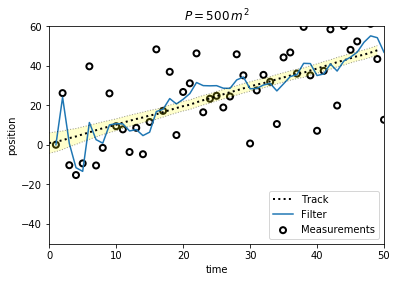

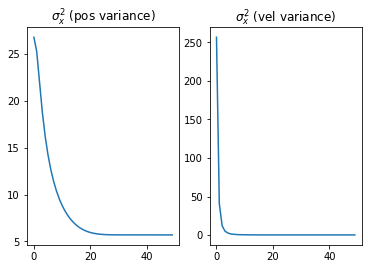

(array([[ 9.44614546e-02,  4.72314358e-02],
        [ 2.41177302e+01,  2.09210266e+01],
        [ 8.17261842e-01, -4.30130198e+00],
        [-1.15004072e+01, -7.64207765e+00],
        [-1.33531277e+01, -5.74596176e+00],
        [ 1.13618393e+01,  2.47539393e+00],
        [ 2.68920036e+00, -8.82629193e-02],
        [ 9.10613151e-01, -4.27930238e-01],
        [ 1.01496875e+01,  1.30430896e+00],
        [ 1.07738469e+01,  1.19374881e+00],
        [ 1.06552642e+01,  9.97297597e-01],
        [ 7.08023377e+00,  3.58365019e-01],
        [ 7.78972093e+00,  4.04736462e-01],
        [ 4.74252401e+00, -3.09956732e-02],
        [ 6.48064773e+00,  1.84620657e-01],
        [ 1.69018923e+01,  1.40005022e+00],
        [ 1.80502278e+01,  1.37071055e+00],
        [ 2.34652129e+01,  1.83641437e+00],
        [ 2.07454585e+01,  1.31549319e+00],
        [ 2.31055851e+01,  1.43453095e+00],
        [ 2.59810365e+01,  1.59861950e+00],
        [ 3.15904010e+01,  2.05586202e+00],
        [ 3.00215241e+01,  1.641

In [35]:
var = 27.5
data = mkf_internal.zs_var_275()
run(track = track, zs = zs, R = var, Q = 0.02, P = 500, plot_P = True, title = '$P=500\,m^{2}$')

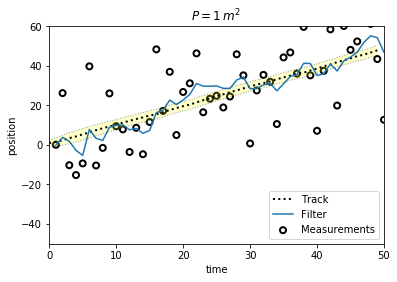

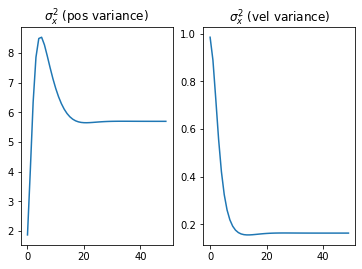

(array([[ 6.59561291e-03,  3.32247832e-03],
        [ 3.86809478e+00,  1.57916166e+00],
        [ 1.82945899e+00,  4.59462145e-01],
        [-2.71418494e+00, -7.68549717e-01],
        [-5.28686595e+00, -1.13538168e+00],
        [ 7.90459414e+00,  1.36361303e+00],
        [ 3.35716758e+00,  4.53496214e-01],
        [ 2.29184804e+00,  2.41994448e-01],
        [ 8.96374027e+00,  1.06929339e+00],
        [ 9.89313507e+00,  1.05234328e+00],
        [ 1.01887579e+01,  9.64545243e-01],
        [ 7.66203873e+00,  5.70992943e-01],
        [ 8.33528086e+00,  5.82326048e-01],
        [ 5.89810729e+00,  2.50146737e-01],
        [ 7.33610506e+00,  3.80744577e-01],
        [ 1.63634552e+01,  1.33519279e+00],
        [ 1.76024138e+01,  1.32449910e+00],
        [ 2.26819164e+01,  1.74503522e+00],
        [ 2.04166130e+01,  1.29234623e+00],
        [ 2.27582757e+01,  1.41165591e+00],
        [ 2.56130077e+01,  1.57676163e+00],
        [ 3.11218465e+01,  2.02891236e+00],
        [ 2.97357779e+01,  1.634

In [36]:
run(track = track, zs = zs, R = var, Q = 0.02, P = 1, plot_P = True, title = '$P=1\,m^{2}$')

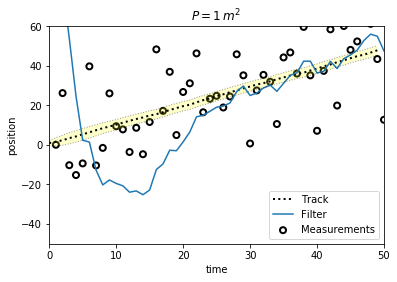

(array([[ 93.21113722,  -3.41982614],
        [ 80.44508366,  -7.23721258],
        [ 53.96398979, -13.19314707],
        [ 24.77348286, -17.11969737],
        [  2.41255385, -18.18539104],
        [  1.4542835 , -15.18050802],
        [-12.71889691, -15.0254108 ],
        [-20.19672705, -13.97437704],
        [-17.72188591, -11.85794825],
        [-19.44194605, -10.62964175],
        [-20.67745699,  -9.53969345],
        [-23.8925291 ,  -8.82675137],
        [-23.24617766,  -7.77677063],
        [-25.17432774,  -7.13335583],
        [-22.78527973,  -6.08641868],
        [-12.44183266,  -4.2728219 ],
        [ -9.59039518,  -3.48116328],
        [ -2.66683068,  -2.31590103],
        [ -2.9190877 ,  -2.08295588],
        [  1.54432616,  -1.33861861],
        [  6.57266356,  -0.61016026],
        [ 14.25502074,   0.34339879],
        [ 14.99674411,   0.38937928],
        [ 17.0304952 ,   0.57972602],
        [ 19.10317164,   0.7528683 ],
        [ 19.67237647,   0.73154401],
        [ 21

In [37]:
x = np.array([100.0, 0.0])
run(track = track, zs = zs, R = var, Q = 0.02, P = 1.0, x0 = x, plot_P = False, title = '$P = 1\,m^{2}$')

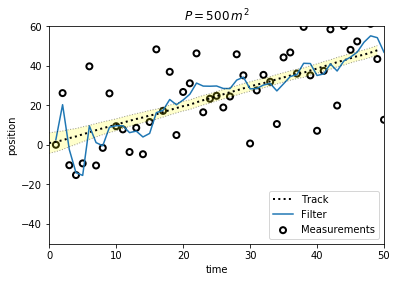

(array([[  2.77084746, -48.61530549],
        [ 20.37332704,   9.0346081 ],
        [ -2.30952929,  -9.0558773 ],
        [-13.99964462, -10.1536811 ],
        [-15.40809348,  -7.28946436],
        [  9.62540975,   1.43445262],
        [  1.19044521,  -0.83516743],
        [ -0.40386071,  -0.98771481],
        [  8.98300046,   0.87131473],
        [  9.729233  ,   0.85098228],
        [  9.7141524 ,   0.72133584],
        [  6.22893991,   0.13351696],
        [  7.01798834,   0.22009065],
        [  4.04253798,  -0.18327748],
        [  5.84634309,   0.05890372],
        [ 16.32844886,   1.29648634],
        [ 17.53369156,   1.28585105],
        [ 23.00220712,   1.76749067],
        [ 20.33296106,   1.26022452],
        [ 22.74076093,   1.3909927 ],
        [ 25.66111572,   1.56515277],
        [ 31.31259704,   2.03101215],
        [ 29.78298746,   1.62421846],
        [ 29.71815511,   1.43074638],
        [ 29.8320375 ,   1.27950422],
        [ 28.57887513,   0.98790606],
        [ 28

In [38]:
x = np.array([100.0, 0.0])
run(track = track, zs = zs, R = var, Q = 0.02, P  = 500, x0 = x, plot_P = False, title = '$P = 500\, m^{2}$')

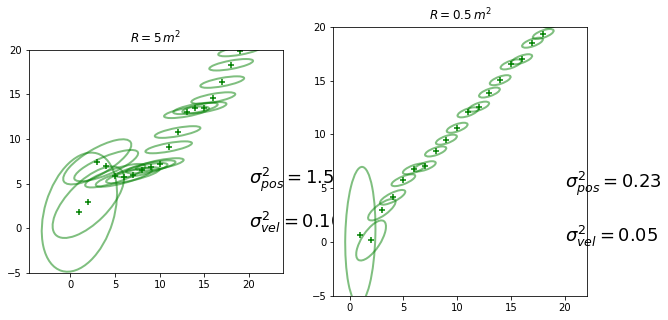

In [39]:
def plot_covariances(count, R, Q = 0, P = 20.0, title = ''):
    track, zs = compute_dog_data(R, Q, count)
    f = pos_vel_filter(x = (0.0, 0.0), R = R, Q = Q, P = P)
    
    xs, cov = [],[]
    for z in zs:
        f.predict()
        f.update(z)
        
        xs.append(f.x[0])
        cov.append(f.P)
    plot_track_ellipses(count, zs, xs, cov, title)

plt.figure(figsize = (10, 10))
plt.subplot(121)
plot_covariances(R = 5, Q = 0.02, count = 20, title = '$R = 5\,m^{2}$')

plt.subplot(122)
plot_covariances(R = 0.5, Q = 0.02, count = 20, title = '$R = 0.5\,m^{2}$')

## Filter Initialization

$$
\Large 
\begin{align}
\textbf{z} &= \textbf{Hx} \\
\textbf{H}^{-1}z &= \textbf{H}^{-1}\textbf{Hx} \\
\textbf{x} &= \textbf{H}^{-1}\textbf{z}
\end{align}
$$

In most of cases, the **H** is not square, we need to compute Moore-Penrose pseudo-inverse of a matrix.

In [40]:
H = np.array([[1.0, 0.0]])
z0 = 3.2
x = np.dot(pinv(H), z0)
print(x)

[[3.2]
 [0. ]]


## Batch Processing


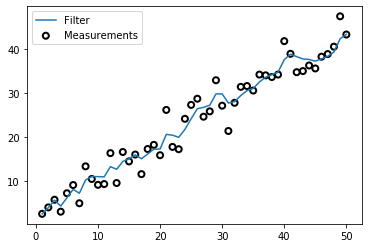

In [41]:
count = 50
track, zs = compute_dog_data(10, 0.2, count)
P = np.diag([500.0, 49.0])
f = pos_vel_filter(x = (0.0, 0.0), R = 3, Q = 0.02, P = P)
xs, _, _, _ = f.batch_filter(zs)

book_plots.plot_measurements(range(1, count + 1), zs)
book_plots.plot_filter(range(1, count + 1), xs[:, 0])
plt.legend(loc = 'best')

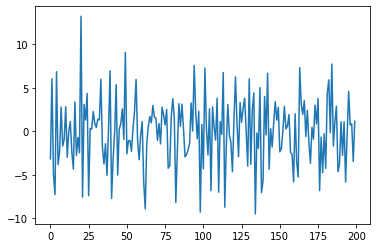

In [42]:
track, zs = compute_dog_data(10, 0.2, 200)
P = np.diag([500.0, 49.0])
f = pos_vel_filter(x = (0.0, 0.0), R = 3.0, Q = 0.02, P = P)
s = Saver(f)
xs, _, _, _ = f.batch_filter(zs, saver = s)
s.to_array()
plt.plot(s.y)

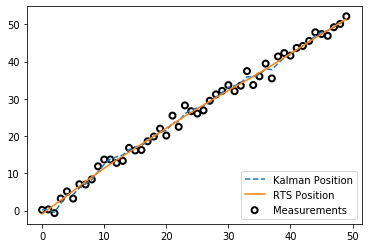

In [43]:
count = 50
np.random.seed(1)

P = np.diag([500.0, 49.0])
f = pos_vel_filter(x = (0.0, 0.0), R = 3, Q = 0.02, P = P)
track, zs = compute_dog_data(3.0, 0.02, count)
Xs, Covs, _, _ = f.batch_filter(zs)
Ms, Ps, _, _ = f.rts_smoother(Xs, Covs)

book_plots.plot_measurements(zs)
plt.plot(Xs[:,0], ls = '--', label = 'Kalman Position')
plt.plot(Ms[:,0], label = 'RTS Position')
plt.legend(loc = 4)

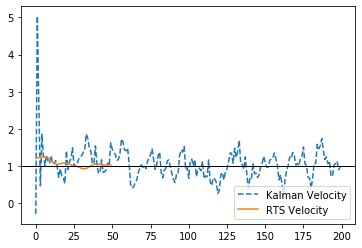

In [44]:
plt.plot(xs[:, 1], ls = '--', label = 'Kalman Velocity')
plt.plot(Ms[:, 1], label = 'RTS Velocity')
plt.legend(loc = 4)
plt.gca().axhline(1, lw = 1, c = 'k')

## Exercise: Compare Velocities

Plot the raw value against the values estimated by the Kalman Filter and by the RTS Filter

In [45]:
print(np.shape(Xs))
print(np.shape(xs))
print(np.shape(Ms))
print(np.shape(dx))


(50, 2)
(200, 2)
(50, 2)


NameError: name 'dx' is not defined

In [ ]:
dx = np.diff(xs[:,0], axis = 0)
plt.figure(figsize = (14, 8))

plt.scatter(range(1, len(dx) + 1), dx, facecolor = 'none', edgecolor = 'k', lw = 2, label = 'Raw Velocity')
plt.plot(xs[:, 1], ls = '--',label = 'Kalman Filter')
plt.plot(Ms[:, 1], label = 'RTS Filter')
plt.xlim(0, 60)
plt.legend(loc = 4)

<font size="5"></font>
$$\huge \begin{align}
f_{x} &= v\Delta t = 15 \times 2 \\
\bar{x}_{k} &= 10 + (15 \times 2) = 40
\end{align}$$
\
#